In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gunel21","key":"ecdf4819a6e02860a1adfc0fca39018f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sujaykapadnis/emotion-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/sujaykapadnis/emotion-recognition-dataset
License(s): CC-BY-NC-SA-4.0


In [ ]:
import zipfile
with zipfile.ZipFile ('/content/emotion-recognition-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
import shutil
shutil.rmtree('/content/dataset/Angry')

In [ ]:
import os
for dirpath, dirnames, filnames in os.walk('/content/dataset'):
    print(f"Thera are {len(dirnames)} directories and {len(filnames)} image in '{dirpath}'.")

Thera are 5 directories and 0 image in '/content/dataset'.
Thera are 0 directories and 1234 image in '/content/dataset/Surprise'.
Thera are 0 directories and 1205 image in '/content/dataset/Ahegao'.
Thera are 0 directories and 4027 image in '/content/dataset/Neutral'.
Thera are 0 directories and 3934 image in '/content/dataset/Sad'.
Thera are 0 directories and 3740 image in '/content/dataset/Happy'.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pathlib

def random_images(target_dir, target_class):
    target_folder=pathlib.Path(target_dir)/ target_class
    random_image=random.choice(os.listdir(target_folder))
    img=mpimg.imread(target_folder/random_image)
    plt.imshow(img)
    plt.axis('off')
    return img.shape

(136, 100, 3)

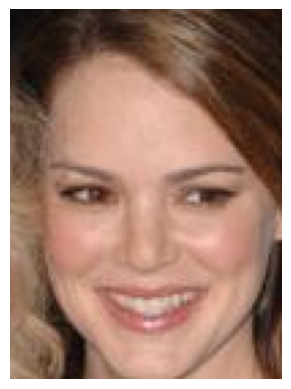

In [ ]:
random_images(target_dir='/content/dataset', target_class='Happy')

In [ ]:
import tensorflow as tf
IMG_SIZE=(224,224)
data='/content/dataset'
train_data=tf.keras.preprocessing.image_dataset_from_directory(data,
                                                               image_size=IMG_SIZE,
                                                               label_mode='categorical',
                                                               subset='training',
                                                               seed=42,
                                                               validation_split=0.2,
                                                               crop_to_aspect_ratio=True
                                                               )
test_data=tf.keras.preprocessing.image_dataset_from_directory(data,
                                                               image_size=IMG_SIZE,
                                                               label_mode='categorical',
                                                               subset='training',
                                                               seed=42,
                                                               validation_split=0.2,
                                                               crop_to_aspect_ratio=True
                                                               )

Found 14140 files belonging to 5 classes.
Using 11312 files for training.
Found 14140 files belonging to 5 classes.
Using 11312 files for training.


<Figure size 1200x1000 with 0 Axes>

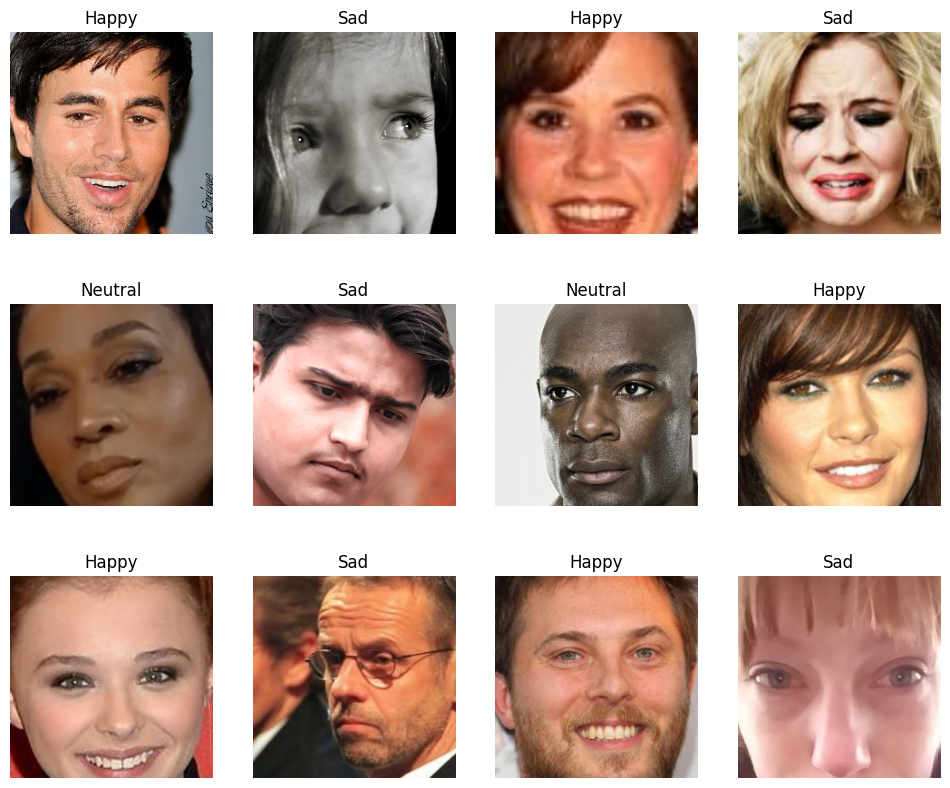

In [ ]:
import numpy as np
plt.figure(figsize=(12,10))
class_names=train_data.class_names
plt.figure(figsize=(12,10))
for image, labels in train_data.take(1):
    for i in range(12):
        ax=plt.subplot(3,4, i+1)
        plt.imshow(image[i]/255)
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis('off')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

input_dir = "/content/dataset/Surprise"
output_dir = "/content/dataset/Surprise"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for img_name in os.listdir(input_dir):
    img_path = os.path.join(input_dir, img_name)
    image = img_to_array(load_img(img_path))
    image = np.expand_dims(image, axis=0)

    i = 0
    for batch in datagen.flow(image, batch_size=1, save_to_dir=output_dir, save_prefix="aug", save_format="jpg"):
        i += 1
        if i > 5:  # Generate 5 augmented images per original
            break

print("Data augmentation completed!")


Data augmentation completed!


In [ ]:
inputs=tf.keras.layers.Input(shape=(224,224,3))
X_data=inputs
Re=tf.keras.layers.Resizing(224,224)(X_data)


x=tf.keras.applications.resnet50.preprocess_input(Re)
base_model=tf.keras.applications.ResNet50(include_top=False, input_tensor=x)

avg=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output=tf.keras.layers.Dense(5,activation='softmax')(avg)
model=tf.keras.Model(inputs,output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
base_model.trainable=False

In [ ]:
initial_lerning_rate=0.01
lr_schedule=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lerning_rate,
    decay_steps=200,
    decay_rate=0.96
)
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=3,
                                               restore_best_weights=True)
checkpoint_cb=tf.keras.callbacks.ModelCheckpoint(
    'emotion_detector.keras',
    save_best_only=True
)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Nadam(lr_schedule),
              metrics=['accuracy','f1_score'])
history=model.fit(train_data,
          validation_data=test_data,
          callbacks=[early_stopping,checkpoint_cb],
          epochs=30)

Epoch 1/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 121s 297ms/step - accuracy: 0.5704 - f1_score: 0.5959 - loss: 1.3306 - val_accuracy: 0.7124 - val_f1_score: 0.7386 - val_loss: 0.8052
Epoch 2/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 114s 239ms/step - accuracy: 0.7008 - f1_score: 0.7315 - loss: 0.8719 - val_accuracy: 0.6501 - val_f1_score: 0.6936 - val_loss: 1.0021
Epoch 3/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 182s 353ms/step - accuracy: 0.7296 - f1_score: 0.7568 - loss: 0.7521 - val_accuracy: 0.7839 - val_f1_score: 0.8144 - val_loss: 0.5747
Epoch 4/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 84s 238ms/step - accuracy: 0.7548 - f1_score: 0.7857 - loss: 0.6875 - val_accuracy: 0.8082 - val_f1_score: 0.8296 - val_loss: 0.5003
Epoch 5/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 83s 235ms/step - accuracy: 0.7671 - f1_score: 0.7965 - loss: 0.6222 - val_accuracy: 0.8023 - val_f1_score: 0.8294 - val_loss: 0.5180
Epoch 6/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 85s 241ms/step - accuracy: 0.7884 - f1_score: 0.8184 - loss: 0.5733 - val_accuracy: 0.8294 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


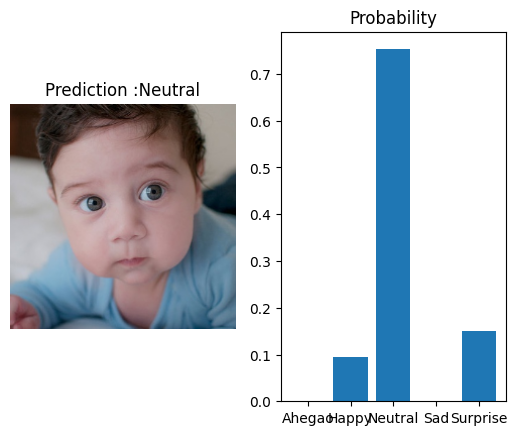

In [ ]:
def pred_and_plot(model, image_path):
    img=mpimg.imread(image_path)
    img=tf.image.resize(img,size=[224,224])
    img=img[tf.newaxis,...]
    pred=model.predict(img)
    plt.subplot(1,2,1)
    plt.imshow(img[0]/255)
    plt.title(f'Prediction :{class_names[np.argmax(pred)]}')
    plt.axis(False)
    plt.subplot(1,2,2)
    plt.bar(class_names, pred[0])
    plt.title('Probability')
    plt.show()
pred_and_plot(model,'/content/00a38a677f128a0ed90c96fd3ea1b0f12ab4e6f77e9365a9da259c04~12fffff.jpg')